In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import polars as pl
import xgboost as xgb
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import warnings

# Suppress warnings globally
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
from collections import Counter
import numpy as np
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
def get_train_test(df, test_size):
    # Make X and Y dataset
    y = df.observation
    print(y.unique())
    X = df.loc[:,'VH_30':'VH_0']
    X['nth'] = df.loc[:,'nth']
    X['nth'] = X.nth.astype('category')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234, stratify=y)
    return X_train, X_test, y_train, y_test

In [3]:
def akurasi_kelas_generatif(y_true, y_pred):
    # Calculate accuracy specifically for class 3
    class_3_mask = (y_true == 3)
    if np.any(class_3_mask):  # Check if class 3 is present in the true labels
        return accuracy_score(y_true[class_3_mask], y_pred[class_3_mask])
    else:
        return 0.0  # Return 0 if class 3 is not present in the true labels

def akurasi_fase_padi(y_true, y_pred):
    # Calculate accuracy specifically for classes 1, 2, 3, and 4
    class_1234_mask = (y_true >= 1) & (y_true <= 4)
    if np.any(class_1234_mask):  # Check if classes 1,2,3,4 are present in the true labels
        return accuracy_score(y_true[class_1234_mask], y_pred[class_1234_mask])
    else:
        return 0.0  # Return 0 if none of the classes 0-3 are present in the true labels

In [4]:
kdprov='53'

In [5]:
# Parameters
kdprov = 53


In [6]:
## Read VH dataset
with open(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/training_VH_v2.pkl','rb') as file:
    df=pickle.load(file)
    if isinstance(df, pl.DataFrame):
        df=df.to_pandas()
print(df.shape)
df.head()

(507905, 44)


,idpoint,idsubsegment,idsegment,nth,periode,observation,class,MGRS,VH_30,VH_29,...,VH_4,VH_3,VH_2,VH_1,VH_0,idkabkota,cluster_data,Sigma0VH_variance,winner,prior
0,530203005A3#03,530203005A3,530203005,1,2022_03,6,NP,51LTJ,-15.003157,-14.839792,...,-13.897276,-14.796861,-14.661230,-15.619116,-14.951990,5302,0,0.829796,R1C13,0.528853
2,530203005A3#09,530203005A3,530203005,1,2022_03,6,NP,51LTJ,-14.024279,-15.679726,...,-13.819187,-14.062122,-13.394154,-15.788738,-13.603525,5302,0,0.829796,R1C13,0.528853
6,530203005A3#10,530203005A3,530203005,1,2022_03,6,NP,51LTJ,-13.940150,-15.205002,...,-14.051441,-13.974236,-12.852287,-15.443974,-13.848682,5302,0,0.829796,R10C3,0.580280
8,530203005A3#16,530203005A3,530203005,1,2022_03,6,NP,51LTJ,-13.811125,-13.073202,...,-13.449095,-13.657732,-13.136038,-13.469506,-13.738852,5302,0,0.829796,R14C14,0.510204
10,530203005A3#18,530203005A3,530203005,1,2022_03,6,NP,51LTJ,-13.002995,-13.710638,...,-12.984497,-12.618353,-11.922312,-12.557711,-12.023638,5302,0,0.829796,R11C12,0.612252


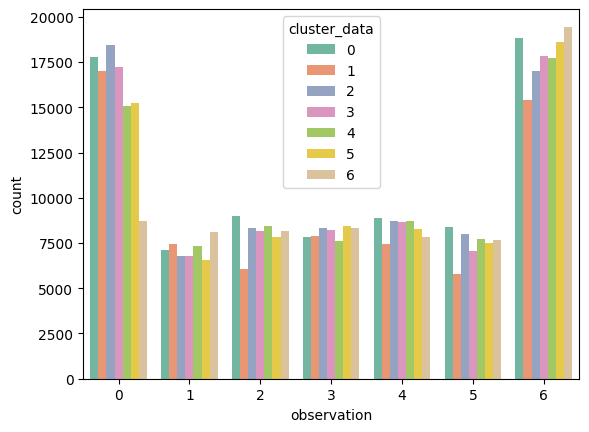

In [7]:
sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))
plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distirbution_plot.png", dpi=300, bbox_inches='tight')

In [14]:
# Import library
import pandas as pd

# Menentukan jumlah sampel minimum dari setiap 'cluster_data'
min_count = df.groupby(['cluster_data','observation'])['observation'].count().min()

# Mengambil sampel agar setiap 'cluster_data' memiliki jumlah 'observation' yang sama
df_balanced = df.groupby(['cluster_data', 'observation']).apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)

# Menampilkan hasil
print(df_balanced['cluster_data'].value_counts())


cluster_data
0    40600
1    40600
2    40600
3    40600
4    40600
5    40600
6    40600
Name: count, dtype: int64


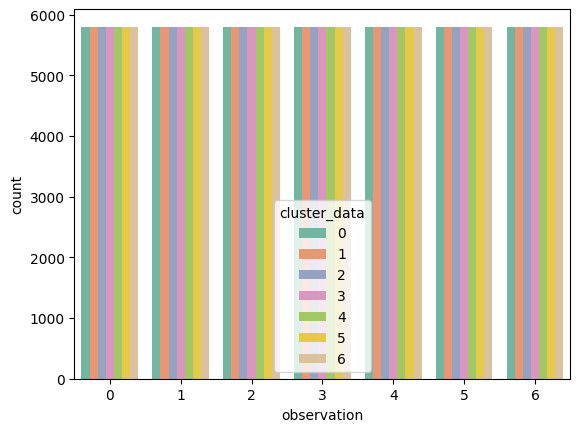

In [15]:
sns.countplot(x='observation', hue='cluster_data', data=df_balanced,palette=sns.color_palette("Set2"))
plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distirbution_plot.png", dpi=300, bbox_inches='tight')

In [18]:
df = df_balanced.copy()

### Running Data

In [19]:
import optuna
from xgboost import XGBClassifier

# Example dataset

# Define the objective function for Bayesian Optimization
def objective(trial,X_train, y_train, n_splits=3):
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        #'subsample': trial.suggest_uniform('subsample', 0.5, 0.7),
        #'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.7),
        #'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 0.7),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.1, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 50, 100),
        'objective': 'multi:softprob',  # Multiclass classification
        'eval_metric': ['mlogloss'],
        "tree_method":'hist',
        "num_class": len(set(y_train)),
        "nthread":20
    }
    
    # Define the model
    skf = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=42)
    f1_macros=[]
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        evals = [(dtrain_fold, 'train'), (dval_fold, 'eval')]
        model = xgb.train(param, dtrain_fold, 
                          num_boost_round=1000, evals=evals,early_stopping_rounds=50,
                          verbose_eval=False)
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
    score=np.mean(f1_macros)
    
    return score

In [22]:
def evaluate_model(X_train, y_train, X_test, y_test,cluster, best_params, n_splits=3):
    # Convert data to DMatrix for XGBoost
    class_counts = Counter(y_train)
    total_samples = len(y_train)
        # Step 3: Calculate class weights as inverse of class frequency
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    sample_weights = np.array([class_weights[label] for label in y_train])
        # Create DMatrix with sample weights
        
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True,weight=sample_weights)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
    
    params = best_params
    params['objective']="multi:softprob"
    #params['tree_method']='approx'
    params['eval_metric']='mlogloss'
    params['num_class']=len(set(y_train))
    params['nthread']=20
    # Stratified K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    accuracies = []
    f1_macros = []
    f1_micros = []
    aucs = []
    acc_kelas_generatifs = []
    acc_fase_padis = []

    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        evals = [(dtrain_fold, 'train'), (dval_fold, 'eval')]
        model = xgb.train(params, dtrain_fold, 
                          num_boost_round=10000, evals=evals,early_stopping_rounds=1000,verbose_eval=100)
        
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        
        accuracies.append(accuracy_score(y_val_fold, y_val_pred))
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
        f1_micros.append(f1_score(y_val_fold, y_val_pred, average='micro'))
        aucs.append(roc_auc_score(y_val_fold, y_val_pred_prob, multi_class='ovr'))
        acc_kelas_generatifs.append(akurasi_kelas_generatif(y_val_fold, y_val_pred))
        acc_fase_padis.append(akurasi_fase_padi(y_val_fold, y_val_pred))

    # Calculate average metrics
    avg_accuracy = sum(accuracies) / len(accuracies)
    avg_f1_macro = sum(f1_macros) / len(f1_macros)
    avg_f1_micro = sum(f1_micros) / len(f1_micros)
    avg_auc = sum(aucs) / len(aucs)
    avg_acc_kelas_generatif = sum(acc_kelas_generatifs) / len(acc_kelas_generatifs)
    avg_acc_fase_padi = sum(acc_fase_padis) / len(acc_fase_padis)
    training_metrics = {
        "average_accuracy": avg_accuracy,
        "average_f1_macro": avg_f1_macro,
        "average_f1_micro": avg_f1_micro,
        "average_auc": avg_auc,
        "average_acc_kelas_generatif": avg_acc_kelas_generatif,
        "average_acc_fase_padi": avg_acc_fase_padi
    }

    
    # Final model evaluation on the test set
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    model = xgb.train(params, dtrain, 
                      num_boost_round=1000, evals=evals,early_stopping_rounds=50,
                      verbose_eval=50)
    y_test_pred_prob = model.predict(dtest)
    y_test_pred = y_test_pred_prob.argmax(axis=1)

    accuracy = accuracy_score(y_test, y_test_pred)
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    f1_micro = f1_score(y_test, y_test_pred, average='micro')
    auc = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr')
    acc_kelas_generatif = akurasi_kelas_generatif(y_test, y_test_pred)
    acc_fase_padi = akurasi_fase_padi(y_test, y_test_pred)
    
    cm = confusion_matrix(y_test, y_test_pred)
    relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
    validation_metrics = {
        "val_accuracy": accuracy,
        "val_f1_macro": f1_macro,
        "val_f1_micro": f1_micro,
        "val_auc": auc,
        "val_acc_kelas_generatif": acc_kelas_generatif,
        "val_acc_fase_padi": acc_fase_padi,
        "val_relative_acc": relative_acc
    }

    print("\nClassification Report on Test Set:")
    report = classification_report(y_test, y_test_pred)
    print(report)
    
    # Display Confusion Matrix
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_cm_cluster_{cluster}_balanced.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return model, training_metrics, validation_metrics, report, cm

CLUSTER:  0


[I 2024-10-29 08:59:30,560] A new study created in memory with name: no-name-b72bedb8-8993-474f-b402-c023f946024a


[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-29 08:59:40,282] Trial 0 finished with value: 0.6687892836725805 and parameters: {'max_depth': 7, 'learning_rate': 0.08843357506403776, 'reg_lambda': 4.996452115075493, 'min_child_weight': 86}. Best is trial 0 with value: 0.6687892836725805.
[I 2024-10-29 08:59:54,804] Trial 1 finished with value: 0.6676636296603081 and parameters: {'max_depth': 7, 'learning_rate': 0.05453130090897565, 'reg_lambda': 0.5152394753546592, 'min_child_weight': 58}. Best is trial 0 with value: 0.6687892836725805.
[I 2024-10-29 09:00:06,522] Trial 2 finished with value: 0.6704286014221742 and parameters: {'max_depth': 8, 'learning_rate': 0.07959124363978089, 'reg_lambda': 4.076175291769102, 'min_child_weight': 79}. Best is trial 2 with value: 0.6704286014221742.
[I 2024-10-29 09:00:19,036] Trial 3 finished with value: 0.672185205577081 and parameters: {'max_depth': 8, 'learning_rate': 0.06908735926399574, 'reg_lambda': 4.9119459669619685, 'min_child_weight': 91}. Best is trial 3 with value: 0.67218

Best Parameters: {'max_depth': 10, 'learning_rate': 0.06783666409012698, 'reg_lambda': 4.90864690342972, 'min_child_weight': 60}
Best Score: 0.6761285244190733
Start the modelling
[0]	train-mlogloss:1.83748	eval-mlogloss:1.85581
[100]	train-mlogloss:0.32040	eval-mlogloss:0.92778
[200]	train-mlogloss:0.16759	eval-mlogloss:0.92866
[300]	train-mlogloss:0.10016	eval-mlogloss:0.95073
[400]	train-mlogloss:0.06873	eval-mlogloss:0.97286
[500]	train-mlogloss:0.05172	eval-mlogloss:0.99433
[600]	train-mlogloss:0.04169	eval-mlogloss:1.01273
[700]	train-mlogloss:0.03513	eval-mlogloss:1.02877
[800]	train-mlogloss:0.03064	eval-mlogloss:1.04283
[900]	train-mlogloss:0.02731	eval-mlogloss:1.05423
[1000]	train-mlogloss:0.02479	eval-mlogloss:1.06587
[1100]	train-mlogloss:0.02282	eval-mlogloss:1.07622
[1131]	train-mlogloss:0.02230	eval-mlogloss:1.07874
[0]	train-mlogloss:1.83851	eval-mlogloss:1.85561
[100]	train-mlogloss:0.31023	eval-mlogloss:0.93056
[200]	train-mlogloss:0.16162	eval-mlogloss:0.92782
[300]

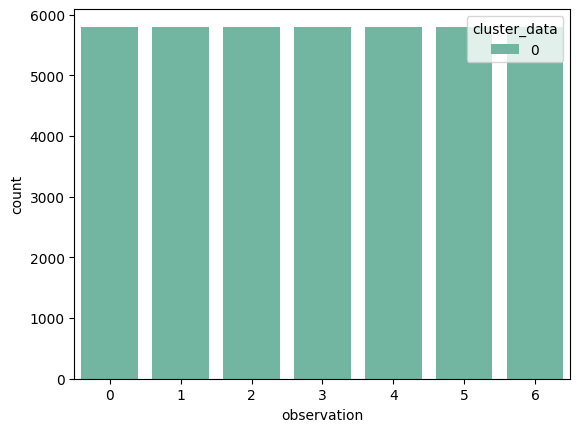

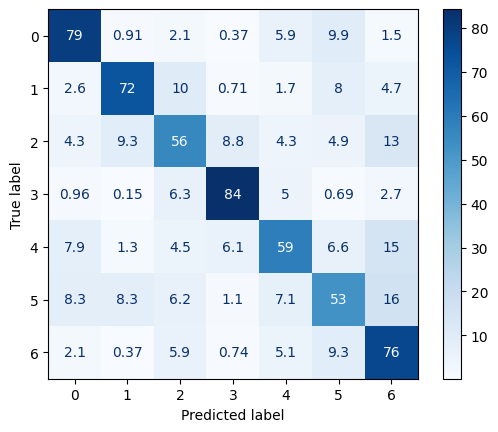

{'average_accuracy': 0.6784072249589491, 'average_f1_macro': np.float64(0.6761083532472685), 'average_f1_micro': np.float64(0.6784072249589491), 'average_auc': np.float64(0.9200185672762963), 'average_acc_kelas_generatif': 0.8195402298850575, 'average_acc_fase_padi': 0.6676724137931034}
{'val_accuracy': 0.6847290640394089, 'val_f1_macro': np.float64(0.6829263730475521), 'val_f1_micro': np.float64(0.6847290640394089), 'val_auc': np.float64(0.9254559264677503), 'val_acc_kelas_generatif': 0.8426108374384237, 'val_acc_fase_padi': 0.6773399014778325, 'val_relative_acc': np.float64(93.98282464894974)}
CLUSTER:  1


[I 2024-10-29 09:04:32,062] A new study created in memory with name: no-name-48d1c2e2-dcc4-48cd-8ccb-2a76dd870c01


[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-29 09:05:02,098] Trial 0 finished with value: 0.7189546977346571 and parameters: {'max_depth': 8, 'learning_rate': 0.03518837762426845, 'reg_lambda': 3.7747973112420263, 'min_child_weight': 78}. Best is trial 0 with value: 0.7189546977346571.
[I 2024-10-29 09:05:38,056] Trial 1 finished with value: 0.7171742065044202 and parameters: {'max_depth': 7, 'learning_rate': 0.030668455238535848, 'reg_lambda': 3.271346087277093, 'min_child_weight': 83}. Best is trial 0 with value: 0.7189546977346571.
[I 2024-10-29 09:06:07,411] Trial 2 finished with value: 0.7229725274843376 and parameters: {'max_depth': 10, 'learning_rate': 0.034591912961435003, 'reg_lambda': 0.4091530118683695, 'min_child_weight': 90}. Best is trial 2 with value: 0.7229725274843376.
[I 2024-10-29 09:06:39,461] Trial 3 finished with value: 0.7180930903463757 and parameters: {'max_depth': 8, 'learning_rate': 0.03244906389492609, 'reg_lambda': 1.2450900104251676, 'min_child_weight': 99}. Best is trial 2 with value: 0.

[400]	train-mlogloss:0.03878	eval-mlogloss:0.24393


[450]	train-mlogloss:0.03290	eval-mlogloss:0.24404


[481]	train-mlogloss:0.02968	eval-mlogloss:0.24438



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88     12816
           1       0.95      0.97      0.96     10671
           2       0.93      0.94      0.94      6606
           3       0.93      0.95      0.94     10453
           4       0.93      0.95      0.94     10836
           5       0.93      0.95      0.94      4497
           6       0.80      0.73      0.77      6666

    accuracy                           0.91     62545
   macro avg       0.91      0.91      0.91     62545
weighted avg       0.91      0.91      0.91     62545



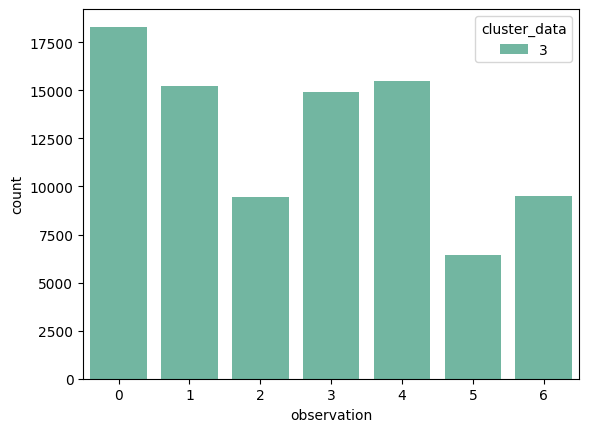

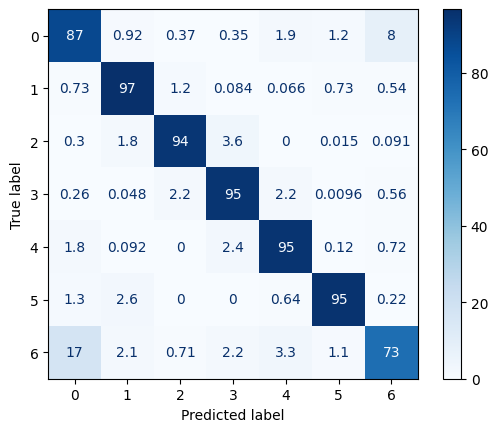

{'average_accuracy': 0.906207861359894, 'average_f1_macro': 0.9013060411749709, 'average_f1_micro': 0.906207861359894, 'average_auc': 0.9886582482324971, 'average_acc_kelas_generatif': 0.9437511899200582, 'average_acc_fase_padi': 0.9496009544056471}
{'val_accuracy': 0.9127827963866016, 'val_f1_macro': 0.9089535041023575, 'val_f1_micro': 0.9127827963866016, 'val_auc': 0.9909863400060598, 'val_acc_kelas_generatif': 0.9470965273127332, 'val_acc_fase_padi': 0.9520302857439196, 'val_relative_acc': 99.92229992229993}
CLUSTER:  4


[I 2024-10-16 17:02:38,170] A new study created in memory with name: no-name-2dbde144-557f-4130-9a88-eca4118d19b7


[0 2 1 3 4 6 5]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-16 17:04:12,569] Trial 0 finished with value: 0.9639883986506321 and parameters: {'max_depth': 6, 'learning_rate': 0.024894990849363613, 'reg_lambda': 0.9980363438478806, 'min_child_weight': 61}. Best is trial 0 with value: 0.9639883986506321.


[I 2024-10-16 17:04:49,948] Trial 1 finished with value: 0.9658529203698465 and parameters: {'max_depth': 6, 'learning_rate': 0.09978245275239626, 'reg_lambda': 1.2548875989830552, 'min_child_weight': 56}. Best is trial 1 with value: 0.9658529203698465.


[I 2024-10-16 17:06:19,334] Trial 2 finished with value: 0.9652706460733583 and parameters: {'max_depth': 9, 'learning_rate': 0.023193434565422825, 'reg_lambda': 0.8276494453725025, 'min_child_weight': 68}. Best is trial 1 with value: 0.9658529203698465.


[I 2024-10-16 17:08:12,042] Trial 3 finished with value: 0.9649660607290002 and parameters: {'max_depth': 6, 'learning_rate': 0.034792085246846495, 'reg_lambda': 3.7704369161799027, 'min_child_weight': 54}. Best is trial 1 with value: 0.9658529203698465.


[I 2024-10-16 17:09:06,638] Trial 4 finished with value: 0.9655282192659046 and parameters: {'max_depth': 8, 'learning_rate': 0.05868385083786465, 'reg_lambda': 0.8915817208569621, 'min_child_weight': 70}. Best is trial 1 with value: 0.9658529203698465.


[I 2024-10-16 17:10:02,986] Trial 5 finished with value: 0.9653318247962104 and parameters: {'max_depth': 7, 'learning_rate': 0.0626138567576201, 'reg_lambda': 2.0907816671962736, 'min_child_weight': 53}. Best is trial 1 with value: 0.9658529203698465.


[I 2024-10-16 17:11:04,956] Trial 6 finished with value: 0.966751523767003 and parameters: {'max_depth': 8, 'learning_rate': 0.05809987272179141, 'reg_lambda': 1.186729164320424, 'min_child_weight': 50}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:11:39,880] Trial 7 finished with value: 0.9655303612510369 and parameters: {'max_depth': 6, 'learning_rate': 0.0942061370232696, 'reg_lambda': 1.9261284081318397, 'min_child_weight': 67}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:12:19,210] Trial 8 finished with value: 0.9655767239032983 and parameters: {'max_depth': 6, 'learning_rate': 0.0957988405843492, 'reg_lambda': 0.2918945949474815, 'min_child_weight': 90}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:13:00,875] Trial 9 finished with value: 0.9652519486583193 and parameters: {'max_depth': 7, 'learning_rate': 0.08790848825535812, 'reg_lambda': 4.504983880513354, 'min_child_weight': 98}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:13:56,968] Trial 10 finished with value: 0.9655166943196667 and parameters: {'max_depth': 10, 'learning_rate': 0.07223022785387949, 'reg_lambda': 3.1613671013290565, 'min_child_weight': 82}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:15:24,236] Trial 11 finished with value: 0.9661847656484128 and parameters: {'max_depth': 8, 'learning_rate': 0.04099940650196007, 'reg_lambda': 1.6876694903582456, 'min_child_weight': 53}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:16:54,943] Trial 12 finished with value: 0.9662971592398654 and parameters: {'max_depth': 8, 'learning_rate': 0.04111130387495585, 'reg_lambda': 2.6356674941868503, 'min_child_weight': 50}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:18:14,368] Trial 13 finished with value: 0.9659079631942834 and parameters: {'max_depth': 8, 'learning_rate': 0.04923321286998059, 'reg_lambda': 2.892668692147892, 'min_child_weight': 79}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:18:57,593] Trial 14 finished with value: 0.9662141932151987 and parameters: {'max_depth': 9, 'learning_rate': 0.07608143826697114, 'reg_lambda': 2.5889153966055884, 'min_child_weight': 60}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:21:22,679] Trial 15 finished with value: 0.9613848576270442 and parameters: {'max_depth': 9, 'learning_rate': 0.01030811773602007, 'reg_lambda': 3.6185225912953896, 'min_child_weight': 62}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:22:24,294] Trial 16 finished with value: 0.9657023637855771 and parameters: {'max_depth': 7, 'learning_rate': 0.0483807679383628, 'reg_lambda': 2.253586439576864, 'min_child_weight': 50}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:23:05,252] Trial 17 finished with value: 0.9659923258129695 and parameters: {'max_depth': 10, 'learning_rate': 0.06977581495256693, 'reg_lambda': 0.18093962534766872, 'min_child_weight': 74}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:24:57,162] Trial 18 finished with value: 0.9661191137652295 and parameters: {'max_depth': 9, 'learning_rate': 0.03626677261157158, 'reg_lambda': 4.933504741907167, 'min_child_weight': 50}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:26:09,736] Trial 19 finished with value: 0.9656810055007004 and parameters: {'max_depth': 7, 'learning_rate': 0.05173645371349073, 'reg_lambda': 1.4655785164775275, 'min_child_weight': 63}. Best is trial 6 with value: 0.966751523767003.


Best Parameters: {'max_depth': 8, 'learning_rate': 0.05809987272179141, 'reg_lambda': 1.186729164320424, 'min_child_weight': 50}
Best Score: 0.966751523767003
Start the modelling


[0]	train-mlogloss:1.78588	eval-mlogloss:1.79410


[100]	train-mlogloss:0.05989	eval-mlogloss:0.15571


[200]	train-mlogloss:0.01978	eval-mlogloss:0.11648


[300]	train-mlogloss:0.01149	eval-mlogloss:0.10941


[400]	train-mlogloss:0.00827	eval-mlogloss:0.10704


[500]	train-mlogloss:0.00658	eval-mlogloss:0.10615


[600]	train-mlogloss:0.00558	eval-mlogloss:0.10574


[700]	train-mlogloss:0.00493	eval-mlogloss:0.10591


[800]	train-mlogloss:0.00445	eval-mlogloss:0.10598


[900]	train-mlogloss:0.00409	eval-mlogloss:0.10625


[1000]	train-mlogloss:0.00381	eval-mlogloss:0.10646


[1100]	train-mlogloss:0.00359	eval-mlogloss:0.10664


[1200]	train-mlogloss:0.00340	eval-mlogloss:0.10682


[1300]	train-mlogloss:0.00325	eval-mlogloss:0.10701


[1400]	train-mlogloss:0.00312	eval-mlogloss:0.10731


[1500]	train-mlogloss:0.00301	eval-mlogloss:0.10740


[1558]	train-mlogloss:0.00295	eval-mlogloss:0.10762


[0]	train-mlogloss:1.78472	eval-mlogloss:1.79218


[100]	train-mlogloss:0.05999	eval-mlogloss:0.15012


[200]	train-mlogloss:0.02028	eval-mlogloss:0.11274


[300]	train-mlogloss:0.01164	eval-mlogloss:0.10538


[400]	train-mlogloss:0.00828	eval-mlogloss:0.10309


[500]	train-mlogloss:0.00658	eval-mlogloss:0.10227


[600]	train-mlogloss:0.00554	eval-mlogloss:0.10229


[700]	train-mlogloss:0.00488	eval-mlogloss:0.10244


[800]	train-mlogloss:0.00440	eval-mlogloss:0.10259


[900]	train-mlogloss:0.00405	eval-mlogloss:0.10293


[1000]	train-mlogloss:0.00377	eval-mlogloss:0.10321


[1100]	train-mlogloss:0.00356	eval-mlogloss:0.10339


[1200]	train-mlogloss:0.00338	eval-mlogloss:0.10367


[1300]	train-mlogloss:0.00322	eval-mlogloss:0.10405


[1400]	train-mlogloss:0.00310	eval-mlogloss:0.10424


[1500]	train-mlogloss:0.00299	eval-mlogloss:0.10456


[1600]	train-mlogloss:0.00289	eval-mlogloss:0.10484


[1625]	train-mlogloss:0.00287	eval-mlogloss:0.10495


[0]	train-mlogloss:1.78538	eval-mlogloss:1.79093


[100]	train-mlogloss:0.06188	eval-mlogloss:0.15035


[200]	train-mlogloss:0.02108	eval-mlogloss:0.11319


[300]	train-mlogloss:0.01200	eval-mlogloss:0.10585


[400]	train-mlogloss:0.00855	eval-mlogloss:0.10413


[500]	train-mlogloss:0.00676	eval-mlogloss:0.10355


[600]	train-mlogloss:0.00569	eval-mlogloss:0.10313


[700]	train-mlogloss:0.00498	eval-mlogloss:0.10324


[800]	train-mlogloss:0.00447	eval-mlogloss:0.10336


[900]	train-mlogloss:0.00411	eval-mlogloss:0.10360


[1000]	train-mlogloss:0.00382	eval-mlogloss:0.10389


[1100]	train-mlogloss:0.00360	eval-mlogloss:0.10418


[1200]	train-mlogloss:0.00341	eval-mlogloss:0.10438


[1300]	train-mlogloss:0.00326	eval-mlogloss:0.10471


[1400]	train-mlogloss:0.00313	eval-mlogloss:0.10500


[1500]	train-mlogloss:0.00302	eval-mlogloss:0.10532


[1600]	train-mlogloss:0.00292	eval-mlogloss:0.10542


[1611]	train-mlogloss:0.00291	eval-mlogloss:0.10542


[0]	train-mlogloss:1.78359	eval-mlogloss:1.78928


[50]	train-mlogloss:0.19054	eval-mlogloss:0.26144


[100]	train-mlogloss:0.06178	eval-mlogloss:0.13962


[150]	train-mlogloss:0.03298	eval-mlogloss:0.11320


[200]	train-mlogloss:0.02166	eval-mlogloss:0.10254


[250]	train-mlogloss:0.01554	eval-mlogloss:0.09722


[300]	train-mlogloss:0.01199	eval-mlogloss:0.09444


[350]	train-mlogloss:0.00978	eval-mlogloss:0.09306


[400]	train-mlogloss:0.00825	eval-mlogloss:0.09221


[450]	train-mlogloss:0.00716	eval-mlogloss:0.09176


[500]	train-mlogloss:0.00634	eval-mlogloss:0.09157


[550]	train-mlogloss:0.00571	eval-mlogloss:0.09143


[600]	train-mlogloss:0.00521	eval-mlogloss:0.09143


[636]	train-mlogloss:0.00492	eval-mlogloss:0.09158



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     13824
           1       0.96      0.95      0.96     12382
           2       0.96      0.97      0.96      9003
           3       0.98      0.98      0.98      8310
           4       0.97      0.98      0.98      9441
           5       0.97      0.97      0.97      8912
           6       0.98      0.99      0.99     10548

    accuracy                           0.97     72420
   macro avg       0.97      0.97      0.97     72420
weighted avg       0.97      0.97      0.97     72420



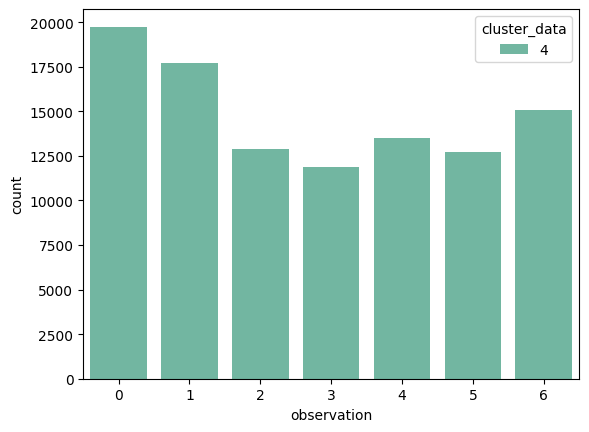

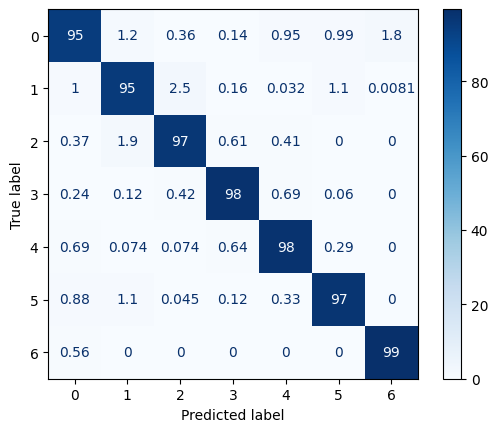

{'average_accuracy': 0.965942818623835, 'average_f1_macro': 0.9670538183098394, 'average_f1_micro': 0.965942818623835, 'average_auc': 0.998772281125114, 'average_acc_kelas_generatif': 0.9817467003650661, 'average_acc_fase_padi': 0.9673284445239373}
{'val_accuracy': 0.9693040596520298, 'val_f1_macro': 0.970398924095045, 'val_f1_micro': 0.9693040596520298, 'val_auc': 0.9990237302143079, 'val_acc_kelas_generatif': 0.9847172081829122, 'val_acc_fase_padi': 0.9696187653311529, 'val_relative_acc': 99.7799849132512}


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
df['observation']=df['observation'].apply(lambda y: int(y))
dict_report={}
for i in list(range(0,7)):
    print('=============================================================================')
    print('CLUSTER: ', i)
    df_x = df.query('cluster_data==@i')
    sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distplot_cluster_{i}_balanced.png", dpi=300, bbox_inches='tight')
    X_train, X_test, y_train, y_test = get_train_test(df_x, 0.7)
    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Output the unique encoded labels and the mapping
    print(np.unique(y_train_encoded))
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Mapping of original to encoded classes:", class_mapping)
    
    # Create an Optuna study and optimize the objective function
    print('Build Best Parameter using Optuna-Hyperparameter Tuning')
    study = optuna.create_study(direction='maximize')  # 'maximize' because we are optimizing accuracy
    study.optimize(lambda trial: objective(trial, X_train, y_train_encoded), n_trials=10)  # Run for 50 trials
    # Print the best parameters and the best score
    print(f"Best Parameters: {study.best_params}")
    print(f"Best Score: {study.best_value}")

    print('Start the modelling')
    model0, training_metrics0, validation_metrics0, report0, cm0 = evaluate_model(
        X_train, y_train_encoded, X_test, y_test_encoded,cluster=i,best_params=study.best_params)
    
    dict_report[i]={'model':model0,
                    'training_metrics':training_metrics0,
                    'validation_metrics':validation_metrics0,
                    'reports':report0,
                    'cm':cm0,
                    'params':study.best_params}
    # Print the training and validation metrics
    print(training_metrics0)
    print(validation_metrics0)
    print('=============================================================================')

In [ ]:
dict_report

In [ ]:
with open(f'/data/ksa/05_Modelling/model/xgboost{kdprov}_v2_new.pkl','wb') as file:
    pickle.dump(dict_report,file)

In [15]:
with open("/data/ksa/05_Modelling/model/xgboost53_v2_5+5.pkl", 'rb') as f:
    dict_report = pickle.load(f)

In [16]:
df = pd.DataFrame()
for cluster_id, metrics in dict_report.items():
    # Training metrics
    df.loc[cluster_id, 'ACCURACY'] = metrics['training_metrics']['average_accuracy']
    df.loc[cluster_id, 'F1 MACRO'] = metrics['training_metrics']['average_f1_macro']
    df.loc[cluster_id, 'F1 MICRO'] = metrics['training_metrics']['average_f1_micro']
    df.loc[cluster_id, 'AUC'] = metrics['training_metrics']['average_auc']
    df.loc[cluster_id, 'ACC [GENERATIVE]'] = metrics['training_metrics']['average_acc_kelas_generatif']
    df.loc[cluster_id, '[FASE PADI]'] = metrics['training_metrics']['average_acc_fase_padi']
    
    # Validation metrics
    df.loc[cluster_id, 'VAL ACCURACY'] = metrics['validation_metrics']['val_accuracy']
    df.loc[cluster_id, 'VAL F1 MACRO'] = metrics['validation_metrics']['val_f1_macro']
    df.loc[cluster_id, 'VAL F1 MICRO'] = metrics['validation_metrics']['val_f1_micro']
    df.loc[cluster_id, 'VAL AUC'] = metrics['validation_metrics']['val_auc']
    df.loc[cluster_id, 'VAL ACC [GENERATIVE]'] = metrics['validation_metrics']['val_acc_kelas_generatif']
    df.loc[cluster_id, 'VAL ACC [FASE PADI]'] = metrics['validation_metrics']['val_acc_fase_padi']
    df.loc[cluster_id, 'RELATIVE ACCURACY'] = metrics['validation_metrics']['val_relative_acc']

df.to_csv("Progress53.csv")

In [17]:
df

,ACCURACY,F1 MACRO,F1 MICRO,AUC,ACC [GENERATIVE],[FASE PADI],VAL ACCURACY,VAL F1 MACRO,VAL F1 MICRO,VAL AUC,VAL ACC [GENERATIVE],VAL ACC [FASE PADI],RELATIVE ACCURACY
5,0.758053,0.719125,0.758053,0.936980,0.655732,0.632290,0.762596,0.726835,0.762596,0.941196,0.656673,0.645502,96.135821
6,0.424646,0.394083,0.424646,0.774667,0.402711,0.368718,0.432106,0.412377,0.432106,0.789845,0.421233,0.401277,83.832924
